In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

tf.enable_eager_execution()
tf.set_random_seed(230)
print(tf.__version__)

from matplotlib import pyplot as plt

import time
import sys
sys.path.append('..')

/Documents/venv3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.11.0


In [16]:
from configs.rnn_biogas import hparams
hparams = hparams()
print(hparams)

### Define Data Generator

In [3]:
from data_loader.biogas import *
get_fields = 'AT305'
dataset, dataset_val, dataset_test = load_data(hparams, mode=get_fields)

### Define Model

In [44]:
class RNN(tf.keras.Model):
    def __init__(self, output_dim, units, batch_size):
        super(RNN, self).__init__()
        self.units = units
        self.output_dim = output_dim
        self.batch_sz = batch_size

        #self.fc_in = tf.keras.layers.Dense(1, activation='relu', name='affine_in')
        
        if tf.test.is_gpu_available():
            self.gru = tf.keras.layers.Bidirectional(\
                            tf.keras.layers.CuDNNGRU(self.units, return_sequences=True, return_state=True, name='gru'))
        else:
            self.gru = tf.keras.layers.Bidirectional(\
                            tf.keras.layers.GRU(self.units, return_sequences=True, return_state=True, 
                                                   recurrent_activation='relu', name='gru'))

        self.fc_out = tf.keras.layers.Dense(self.output_dim, activation='linear', name='affine_out')

    def call(self, x, hidden):
        #x = self.fc_in(x)
        
        output, states, _ = self.gru(x, initial_state=self.reset_states())

        x = x[:,-1:, -1:] + self.fc_out(output)

        return x


### Train Model

In [75]:
loss, accuracy, run_time, stats = trainer.train_model(model, optimizer, dataset, hparams,
                                                      epochs=40, verbose=True, dev_dataset=dataset_val)

Epoch 1 Loss 0.0007 Accuracy 0.0005
Time taken for 1 epoch 4.5556 sec

Epoch 2 Loss 0.0007 Accuracy 0.0005
Time taken for 1 epoch 4.0149 sec

Epoch 3 Loss 0.0007 Accuracy 0.0005
Time taken for 1 epoch 3.9463 sec

Epoch 4 Loss 0.0007 Accuracy 0.0005
Time taken for 1 epoch 3.7953 sec

Epoch 5 Loss 0.0007 Accuracy 0.0005
Time taken for 1 epoch 3.9673 sec

Epoch 6 Loss 0.0007 Accuracy 0.0005
Time taken for 1 epoch 4.3587 sec

Epoch 7 Loss 0.0007 Accuracy 0.0005
Time taken for 1 epoch 3.8438 sec

Epoch 8 Loss 0.0007 Accuracy 0.0005
Time taken for 1 epoch 4.1089 sec

Epoch 9 Loss 0.0007 Accuracy 0.0005
Time taken for 1 epoch 3.9818 sec

Epoch 10 Loss 0.0007 Accuracy 0.0005
Time taken for 1 epoch 3.9280 sec

Epoch 11 Loss 0.0007 Accuracy 0.0005
Time taken for 1 epoch 3.9344 sec

Epoch 12 Loss 0.0007 Accuracy 0.0005
Time taken for 1 epoch 3.7785 sec

Epoch 13 Loss 0.0007 Accuracy 0.0005
Time taken for 1 epoch 4.0186 sec

Epoch 14 Loss 0.0007 Accuracy 0.0005
Time taken for 1 epoch 4.1399 sec

E

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/Documents/venv3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/Documents/venv3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/Documents/venv3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()  File "/Documents/venv3/lib/python3.6/site-packages/tornado/platfo

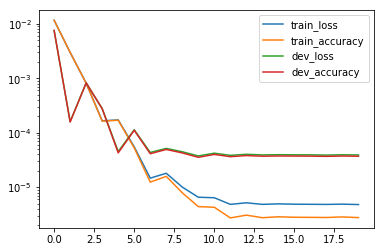

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_13 (Bidirectio multiple                  7296      
_________________________________________________________________
affine_out (Dense)           multiple                  65        
Total params: 7,361
Trainable params: 7,361
Non-trainable params: 0
_________________________________________________________________


In [45]:
import trainers.tf_eager_trainer as trainer

# Run a training batch
tf.set_random_seed(231) # Set seed

# Initialise model and optimiser
model_ = RNN(hparams.output_dim, hparams.neurons_unit, hparams.batch_size)
optimizer_ = tf.train.AdamOptimizer(learning_rate = hparams.learning_rate)

# Start training run
loss, accuracy, run_time, stats = trainer.train_model(model_, optimizer_, dataset, hparams,
                                                      epochs=20, verbose=True, dev_dataset=dataset_val)

# Display results
print('Loss {:.4f} Accuracy {:.4f} Time {:.4f}'.format(loss * 100, accuracy * 100, run_time))

plt.figure()
for name, stat in stats.items():
    if name != 'time':
        plt.plot(stat, label=name)
plt.legend()
plt.yscale('log')
plt.show()

trainer.save_model(model_, optimizer_, dataset_val, hparams, 'birnn_affine_' + get_fields.replace(' ', '_'), stats=stats)
model_.summary()

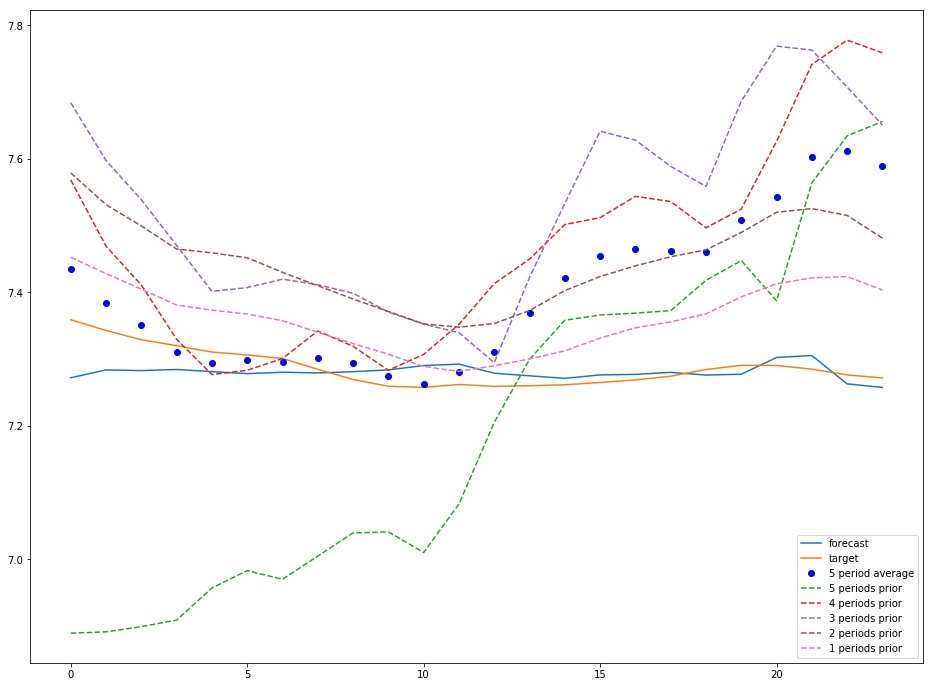

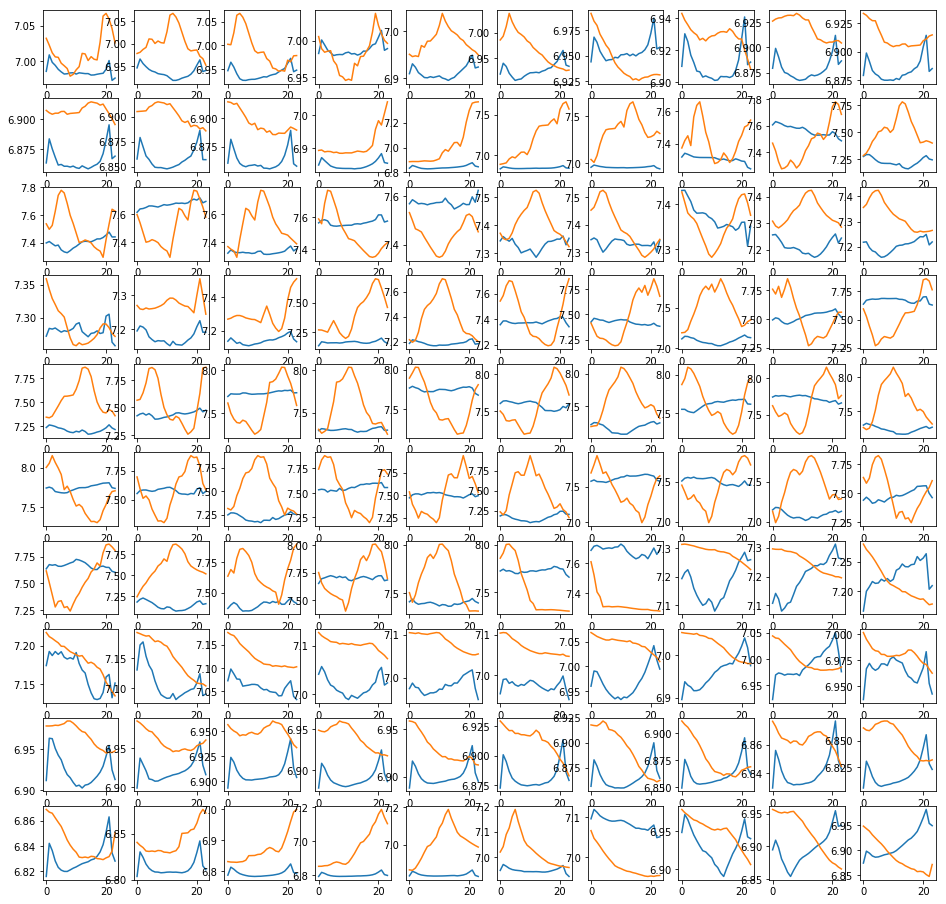

In [74]:
# show all sequences
# Select target sequence to show
TARGET_INDEX = 240

# Create forecast and rescale data
inp, target, mask, x_max = next(iter(dataset_val))
hidden = model_.reset_states()
forecast = model_(inp, hidden)
forecast *= tf.keras.backend.expand_dims(x_max)
target   *= tf.keras.backend.expand_dims(x_max)
inp = np.reshape(inp, [hparams.batch_size, hparams.in_seq_len, hparams.input_dim, hparams.input_channels])
inp *= np.reshape(x_max, [hparams.batch_size,1,1,-1])

# Plot target sequence
plt.figure(figsize=(16,12))
plt.plot(np.squeeze(forecast[TARGET_INDEX,:,0]), label='forecast')
plt.plot(np.squeeze(target[TARGET_INDEX,:,0]), label='target')
plt.plot(np.mean(inp, axis=2)[TARGET_INDEX,:,0], 'bo', label='5 period average')
for i in range(hparams.input_dim):
    plt.plot(np.array(inp)[TARGET_INDEX,:,i,0], '--', label='%i periods prior' % (5-i))
plt.legend()
plt.show()

# Plot specimen predictions
plt.figure(figsize=(16,16))
for i in range(0,800,8):
    ax = plt.subplot(10,10,i/8+1)
    ax.plot(np.squeeze(forecast[i]), label='forecast')
    ax.plot(np.squeeze(target[i]), label='target')
plt.show()

### Test Hyperparameters

In [31]:
np.random.seed(231)
models = []

#for nodes in np.floor(2 ** np.arange(3,9)):
#for lr in np.random.uniform(-8, -1, 10):
for lr in range(-7, -2, 1):
    lr /= 2

    # Run a training batch
    tf.set_random_seed(231) # Set seed

    # Initialise model and optimiser
    model = RNN(hparams.output_dim, hparams.neurons_unit, hparams.batch_size)
    optimizer = tf.train.AdamOptimizer(learning_rate = 10 ** lr)

    # Start training run
    loss, accuracy, run_time, stats = trainer.train_model(model, optimizer, dataset, hparams,
                                                          epochs=20, verbose=False, dev_dataset=dataset_val)
    print('Learning Rate {:.4f} Loss {:.4f} Accuracy {:.4f} Time {:.1f}'.format(lr, loss*100, accuracy * 100, run_time))
    
    models.append(model)

Learning Rate -3.0000 Loss 0.0074 Accuracy 0.0072 Time 79.0
Learning Rate -2.5000 Loss 0.0012 Accuracy 0.0010 Time 78.3
Learning Rate -2.0000 Loss 0.0025 Accuracy 0.0021 Time 78.9
Learning Rate -1.5000 Loss nan Accuracy nan Time 82.2


## Test Model Accuracy

In [37]:
model_accuracy = []

Total Accuracy: 608298048.0000


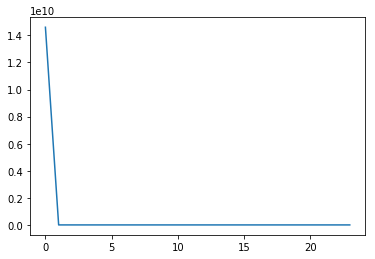

In [66]:
START_POINT = 0
total_accuracy = []
x_variance = x_var(hparams, mode=get_fields, normalise='local_max_min')

for i, (inp, target, mask, x_max) in enumerate(dataset_val):
    forecast = model(inp, mask)

    accuracy = tf.squeeze(forecast - target) * x_max
    accuracy = accuracy ** 2 / x_variance
    accuracy = np.mean(accuracy, axis=0)
    
    total_accuracy.append(accuracy)

model_accuracy.append((hparams.in_seq_len, np.mean(total_accuracy, axis=0)))
    
print('Total Accuracy: %.4f' % np.mean(total_accuracy))
plt.plot(np.mean(total_accuracy, axis=0))
plt.show()